# Imports, read dataset, create folder_paths

In [98]:
import os, shutil, random, cv2, numpy as np, torch
import torch.nn as nn
from pathlib import Path
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report

In [99]:
def read_images_and_labels(data_dir):
    images = []
    labels = []
    for img_file in os.listdir(data_dir / "images"):
        if img_file.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            img_path = data_dir / "images" / img_file
            label_file = img_file.replace('.jpg', '.txt').replace('.jpeg', '.txt').replace('.png', '.txt').replace('.bmp', '.txt')
            lbl_path = data_dir / "labels" / label_file
            
            if lbl_path.exists():
                with open(lbl_path, 'r') as f:
                    label = f.readline().strip()
                images.append(img_path)
                labels.append(label)
    return images, labels

In [100]:
data_dir = Path("../data/new_dataset")
images, labels = read_images_and_labels(data_dir)

In [101]:
new_dataset_path = Path("../data/new_dataset")
new_image_folder = new_dataset_path / "images"
new_label_folder = new_dataset_path / "labels"

cropped_image_folder = Path("../data/new_dataset/cropped_images")
cropped_label_folder = Path("../data/new_dataset/cropped_labels")
filtered_image_folder = Path("../data/new_dataset/filtered_images")
filtered_label_folder = Path("../data/new_dataset/filtered_labels")

In [102]:
IMAGE_EXTENSIONS = {'.jpg', '.jpeg', '.png', '.bmp'}
CLASS_ID_TO_NAME = {0: 'car', 1: 'traffic light', 2: 'pedestrian'}
CLASS_NAMES_LIST = ['car', 'traffic light', 'pedestrian']
NUM_CLASSES = 3
IMG_SIZE = 128


# Basic cropping - take only the cropped images that are relatively big

In [103]:
def yolo_to_pixel_box(x_c, y_c, w, h, img_w, img_h):
    box_w = w * img_w
    box_h = h * img_h

    xmin = int((x_c * img_w) - (box_w / 2))
    ymin = int((y_c * img_h) - (box_h / 2))
    xmax = int(xmin + box_w)
    ymax = int(ymin + box_h)

    xmin = max(0, xmin)
    ymin = max(0, ymin)
    xmax = min(img_w, xmax)
    ymax = min(img_h, ymax)
    return xmin, ymin, xmax, ymax

def crop_yolo_subpix(img: np.ndarray, x_c: float, y_c: float, w: float, h: float) -> np.ndarray:
    H, W = img.shape[:2]
    patch_w = w * W
    patch_h = h * H
    center  = (x_c * W, y_c * H)
    size    = (int(round(patch_w)), int(round(patch_h)))
    return cv2.getRectSubPix(img, patchSize=size, center=center)

def process_single_image_test_only(
    img_path: Path,
    lbl_path: Path,
    output_image_dir: Path,
    output_label_dir: Path
):
    pil_img = Image.open(img_path).convert("RGB")
    img_w, img_h = pil_img.size
    img_cv = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)
    TEST_CLASSES = {3, 2}
    TEST_CLASS_NAMES = {
        3: "pedestrian",
        2: "car"
    }

    if not lbl_path.exists():
        print(f"No label for {img_path.name}")
        return

    with open(lbl_path, "r") as f:
        lines = [l.strip() for l in f if l.strip()]

    for row in lines:
        parts = row.split()
        cls_id = int(parts[0])
        if cls_id not in TEST_CLASSES:
            continue

        x_c, y_c, w_n, h_n = map(float, parts[1:5])
        class_name = TEST_CLASS_NAMES.get(cls_id)
        base_name = f"{img_path.stem}_{int(x_c*img_w)}_{int(y_c*img_h)}_{int(w_n*img_w)}_{int(h_n*img_h)}"
        patch_cv = crop_yolo_subpix(img_cv, x_c, y_c, w_n, h_n)
        patch_pil = Image.fromarray(cv2.cvtColor(patch_cv, cv2.COLOR_BGR2RGB))
        patch_pil.save(output_image_dir / f"{base_name}.jpg")
        with open(output_label_dir / f"{base_name}.txt", "w") as lf:
            lf.write(class_name + "\n")

def filter_test_only_by_size(
    image_dir: Path,
    label_dir: Path,
    output_image_dir: Path,
    output_label_dir: Path,
    min_size_pixels: int = 50,
    min_ratio: float = None,
    img_original_dir: Path = None
):
    output_image_dir.mkdir(parents=True, exist_ok=True)
    output_label_dir.mkdir(parents=True, exist_ok=True)
    processed_count = 0
    kept_count = 0
    print(f"Filtering test-only crops by size (min_size_pixels={min_size_pixels}, min_ratio={min_ratio})...")

    for cropped_img_path in sorted(image_dir.iterdir()):
        if cropped_img_path.suffix.lower() not in IMAGE_EXTENSIONS:
            continue

        processed_count += 1
        base_name = cropped_img_path.stem
        cropped_lbl_path = label_dir / f"{base_name}.txt"

        if not cropped_lbl_path.exists():
            print(f"Warning: Label not found for {cropped_img_path.name}")
            continue
        try:
            parts = base_name.split('_')
            coord_parts_indices = [i for i, part in enumerate(parts) if part.isdigit()][-4:]
            if len(coord_parts_indices) != 4:
                 print(f"Warning: Could not parse dimensions from name {base_name}. Skipping.")
                 continue

            orig_img_stem_parts = parts[:coord_parts_indices[0]]
            orig_img_stem = '_'.join(orig_img_stem_parts)
            orig_xc_px = int(parts[coord_parts_indices[0]])
            orig_yc_px = int(parts[coord_parts_indices[1]])
            orig_w_px = int(parts[coord_parts_indices[2]])
            orig_h_px = int(parts[coord_parts_indices[3]])

            is_big_enough = False

            if min_ratio is not None:
                if img_original_dir is None:
                    raise ValueError("img_original_dir must be provided when min_ratio is used.")
                original_img_path = None
                for suffix in IMAGE_EXTENSIONS:
                    candidate_path = img_original_dir / f"{orig_img_stem}{suffix}"
                    if candidate_path.exists():
                        original_img_path = candidate_path
                        break

                if original_img_path:
                    try:
                        with Image.open(original_img_path) as original_img:
                            orig_img_w, orig_img_h = original_img.size
                            if orig_img_w > 0 and orig_img_h > 0:
                                bbox_area = orig_w_px * orig_h_px
                                total_area = orig_img_w * orig_img_h
                                if total_area > 0 and (bbox_area / total_area) >= min_ratio:
                                    is_big_enough = True
                            else:
                                print(f"Warning: Original image {original_img_path} has zero dimension. Skipping.")
                    except Exception as e:
                        print(f"Error opening original image {original_img_path}: {e}. Skipping.")
                else:
                    print(f"Warning: Original image not found for stem {orig_img_stem}. Cannot apply min_ratio. Skipping.")
            elif min_size_pixels is not None:
                 if orig_w_px >= min_size_pixels or orig_h_px >= min_size_pixels:
                     is_big_enough = True
            else:
                 is_big_enough = True


            if is_big_enough:
                kept_count += 1
                shutil.copy2(cropped_img_path, output_image_dir / cropped_img_path.name)
                shutil.copy2(cropped_lbl_path, output_label_dir / cropped_lbl_path.name)

        except Exception as e:
            print(f"Error processing {cropped_img_path.name}: {e}. Skipping.")

    print(f"Finished filtering. Processed {processed_count} crops, kept {kept_count}.")
    print(f"Filtered images saved to: {output_image_dir}")
    print(f"Filtered labels saved to: {output_label_dir}")

In [104]:
cropped_image_folder.mkdir(parents=True, exist_ok=True)
cropped_label_folder.mkdir(parents=True, exist_ok=True)
for img_path in new_image_folder.iterdir():
  if img_path.suffix.lower() in IMAGE_EXTENSIONS:
    lbl_path = new_label_folder / f"{img_path.stem}.txt"
    process_single_image_test_only(img_path, lbl_path, cropped_image_folder, cropped_label_folder)

In [105]:
filter_test_only_by_size(
    cropped_image_folder, cropped_label_folder,
    filtered_image_folder, filtered_label_folder,
    min_size_pixels=50
)

Filtering test-only crops by size (min_size_pixels=50, min_ratio=None)...
Finished filtering. Processed 2561 crops, kept 1417.
Filtered images saved to: ..\data\new_dataset\filtered_images
Filtered labels saved to: ..\data\new_dataset\filtered_labels


# Class, resize to our model prerequisite 

In [106]:
class CroppedImageDataset(Dataset):
    def __init__(self, image_dir: Path, label_dir: Path, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform

        self.samples = []
        for img_path in sorted(self.image_dir.iterdir()):
            if img_path.suffix.lower() not in IMAGE_EXTENSIONS:
                continue
            lbl_path = self.label_dir / f"{img_path.stem}.txt"
            if lbl_path.exists():
                self.samples.append((img_path, lbl_path))
        if len(self.samples) == 0:
            raise RuntimeError("No cropped image/label pairs found.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, lbl_path = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        with open(lbl_path, "r") as f:
            class_name = f.readline().strip()
        label_idx = CLASS_NAMES_LIST.index(class_name)
        return img, label_idx

In [107]:
test_only_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

test_only_filtered_dataset = CroppedImageDataset(filtered_image_folder, filtered_label_folder, transform = test_only_transform)
test_only_filtered_loader = DataLoader(test_only_filtered_dataset, batch_size=64, shuffle=True, num_workers=0)
print(f"\nNumber of filtered test only samples: {len(test_only_filtered_dataset)}")


Number of filtered test only samples: 1417


# Load pretrained model

In [108]:
import sys
from pathlib import Path

project_root = Path.cwd().parent  
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

In [109]:
from src.models.models import SimpleCNN 
from src.testing.evaluate import load_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "../model_checkpoints/best_model_simplecnn.pth"
num_classes = 3
img_size = 128 

model = load_model(SimpleCNN, model_path, device, num_classes, img_size=img_size)

In [110]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
model.eval()


SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

# Evaluate

In [111]:
import torch

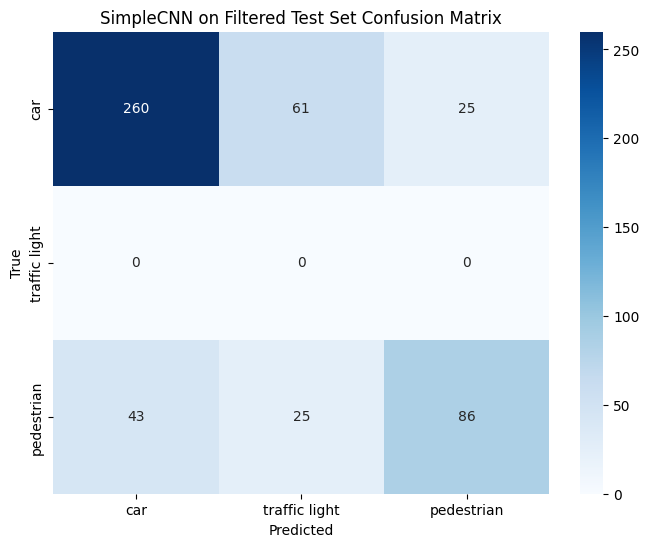


Filtered Test Accuracy: 0.6920


In [115]:
all_preds = []
all_labels = []
max_samples = 500
sample_count = 0

with torch.no_grad():
    for imgs, labels in test_only_filtered_loader:
        if sample_count >= max_samples:
            break
        batch_size = imgs.size(0)
        remaining = max_samples - sample_count
        if batch_size > remaining:
            imgs = imgs[:remaining]
            labels = labels[:remaining]
            batch_size = remaining
        imgs = imgs.to(device)
        labels = labels.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        sample_count += batch_size

cm_filtered = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_filtered, annot=True, fmt='d', cmap="Blues", xticklabels=CLASS_NAMES_LIST, yticklabels=CLASS_NAMES_LIST)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("SimpleCNN on Filtered Test Set Confusion Matrix")
plt.show()

correct_filtered = (np.array(all_preds) == np.array(all_labels)).sum()
total_filtered = len(all_labels)
accuracy_filtered = correct_filtered / total_filtered if total_filtered > 0 else 0

print(f"\nFiltered Test Accuracy: {accuracy_filtered:.4f}")

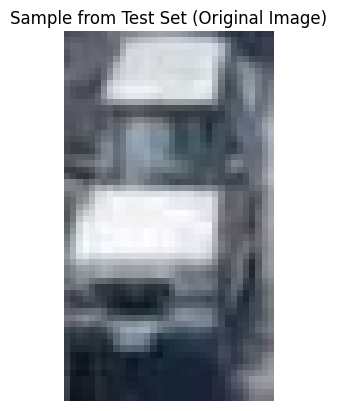

Model Prediction: car
Real Label:       car
------------------------------


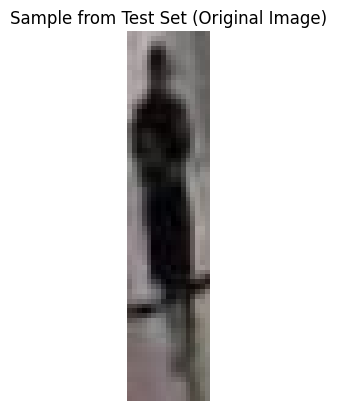

Model Prediction: pedestrian
Real Label:       pedestrian
------------------------------


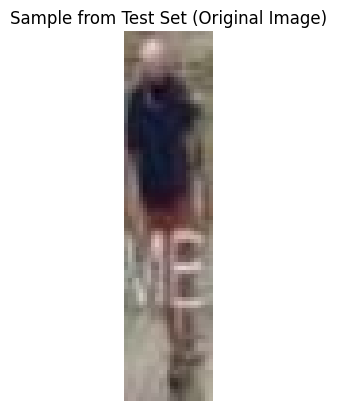

Model Prediction: pedestrian
Real Label:       pedestrian
------------------------------


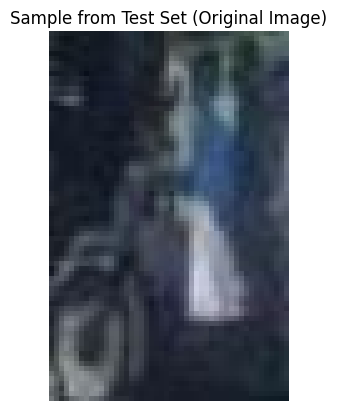

Model Prediction: traffic light
Real Label:       pedestrian
------------------------------


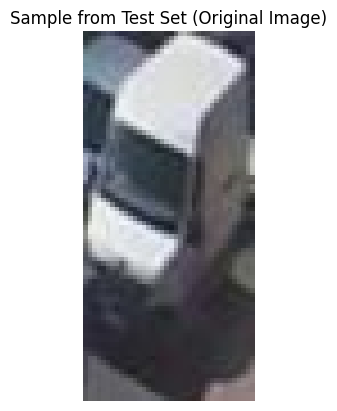

Model Prediction: car
Real Label:       car
------------------------------


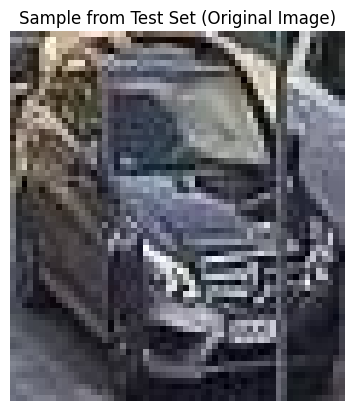

Model Prediction: car
Real Label:       car
------------------------------


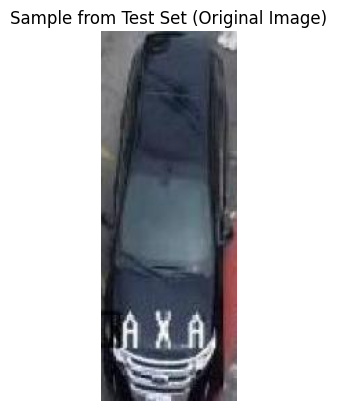

Model Prediction: pedestrian
Real Label:       car
------------------------------


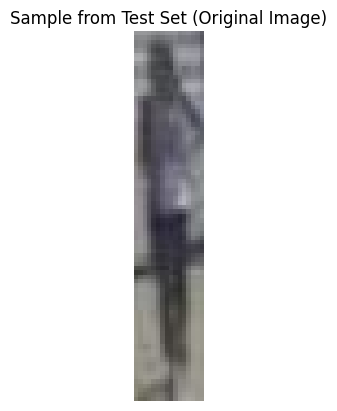

Model Prediction: pedestrian
Real Label:       pedestrian
------------------------------


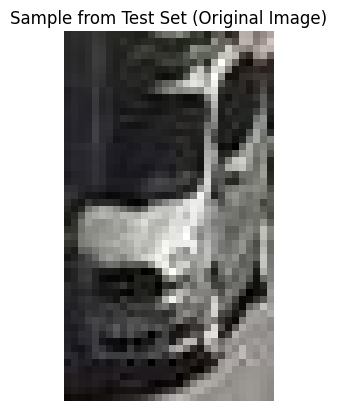

Model Prediction: car
Real Label:       car
------------------------------


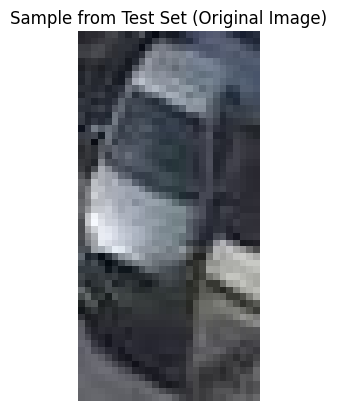

Model Prediction: car
Real Label:       car
------------------------------


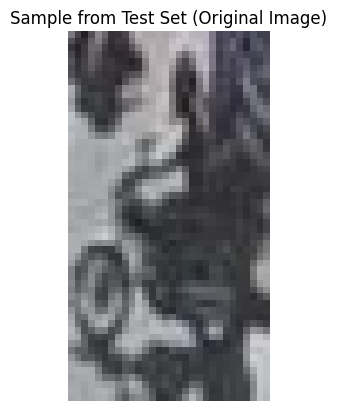

Model Prediction: car
Real Label:       pedestrian
------------------------------


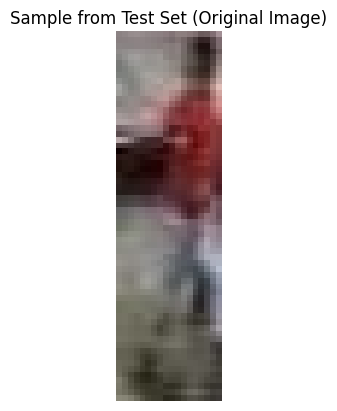

Model Prediction: pedestrian
Real Label:       pedestrian
------------------------------


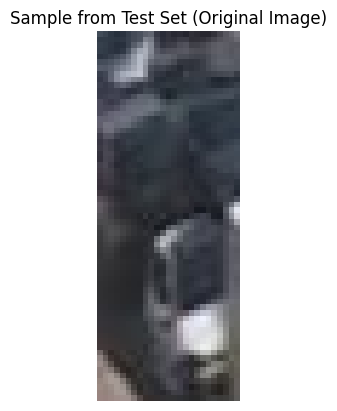

Model Prediction: pedestrian
Real Label:       car
------------------------------


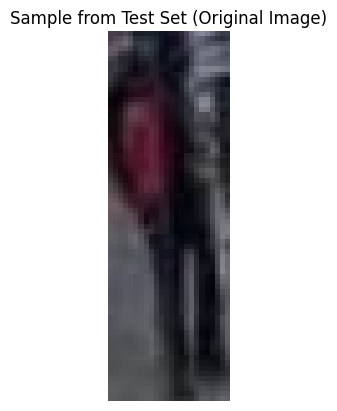

Model Prediction: pedestrian
Real Label:       pedestrian
------------------------------


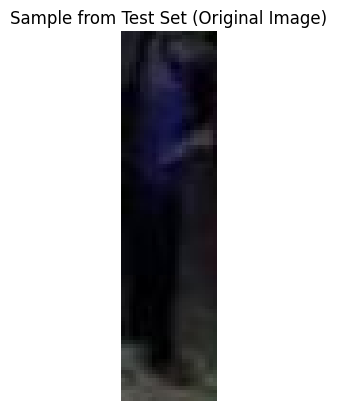

Model Prediction: car
Real Label:       pedestrian
------------------------------


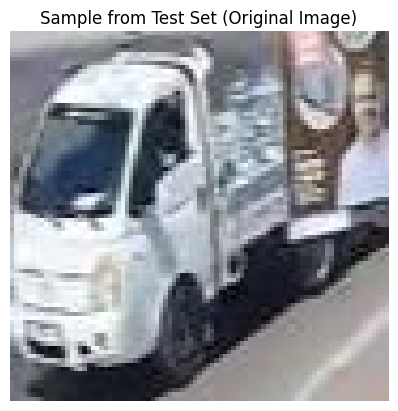

Model Prediction: car
Real Label:       car
------------------------------


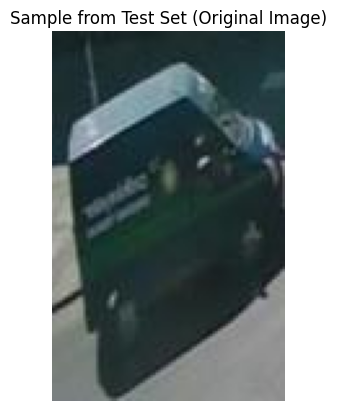

Model Prediction: car
Real Label:       car
------------------------------


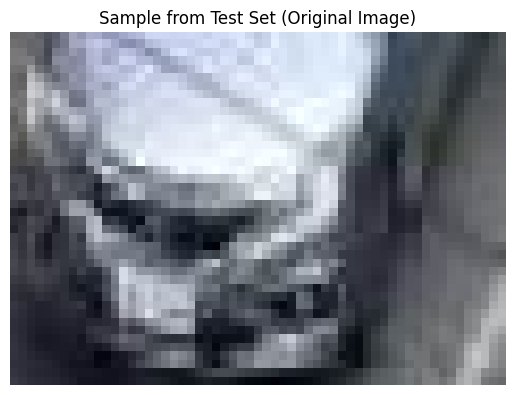

Model Prediction: traffic light
Real Label:       car
------------------------------


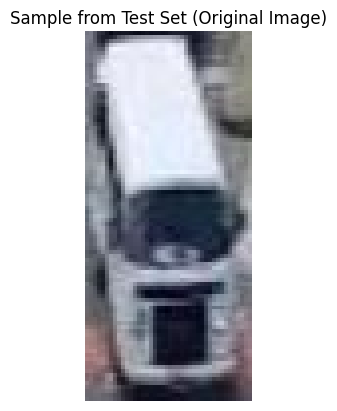

Model Prediction: car
Real Label:       car
------------------------------


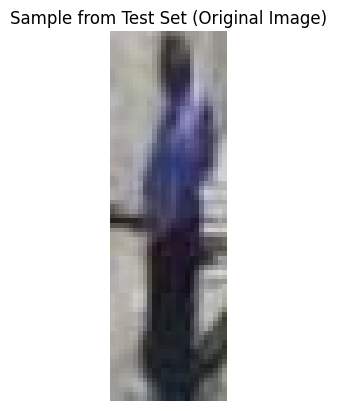

Model Prediction: car
Real Label:       pedestrian
------------------------------


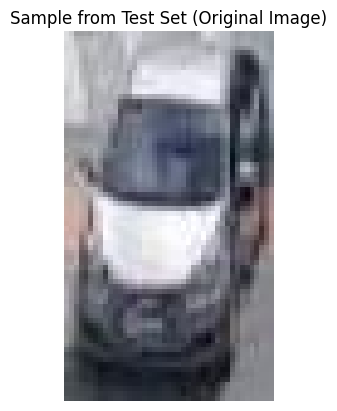

Model Prediction: car
Real Label:       car
------------------------------


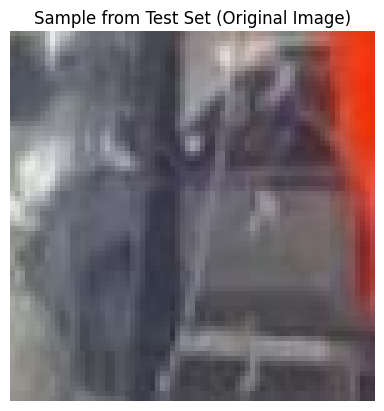

Model Prediction: car
Real Label:       car
------------------------------


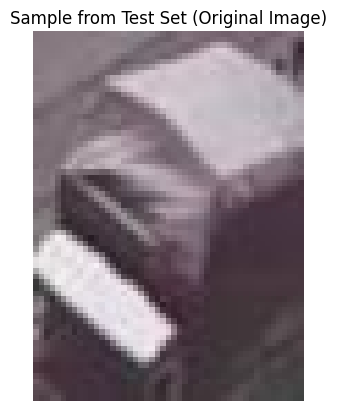

Model Prediction: car
Real Label:       car
------------------------------


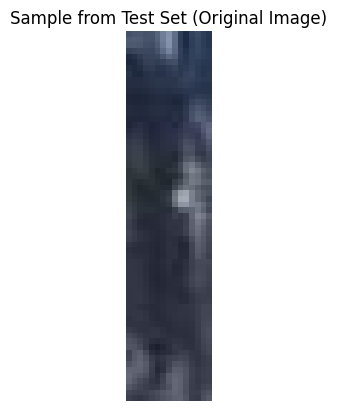

Model Prediction: traffic light
Real Label:       pedestrian
------------------------------


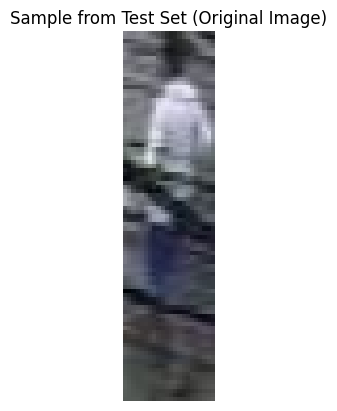

Model Prediction: car
Real Label:       pedestrian
------------------------------


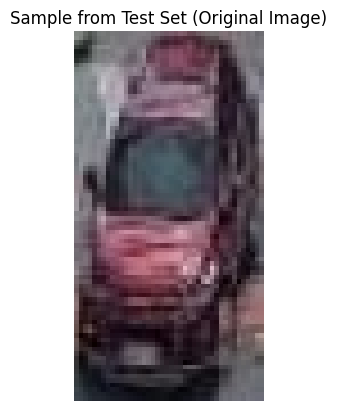

Model Prediction: car
Real Label:       car
------------------------------


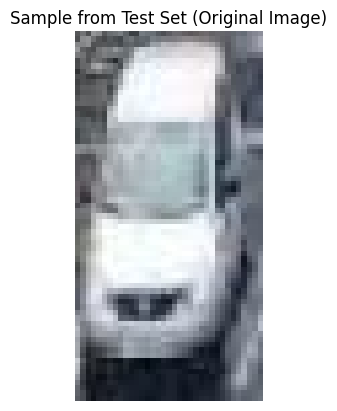

Model Prediction: traffic light
Real Label:       car
------------------------------


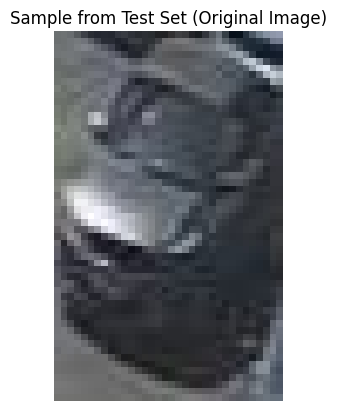

Model Prediction: car
Real Label:       car
------------------------------


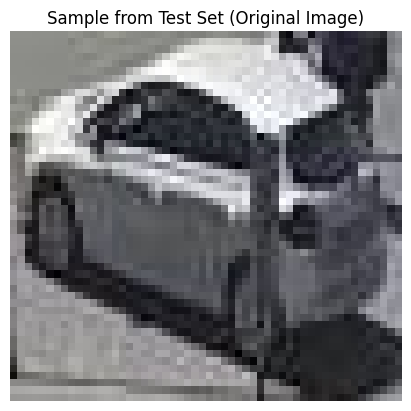

Model Prediction: car
Real Label:       car
------------------------------


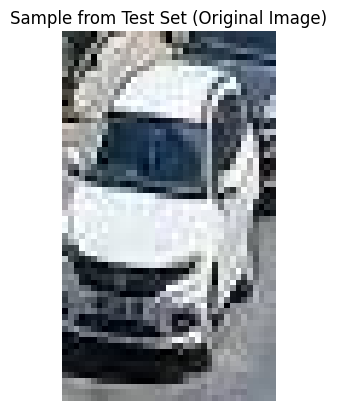

Model Prediction: car
Real Label:       car
------------------------------


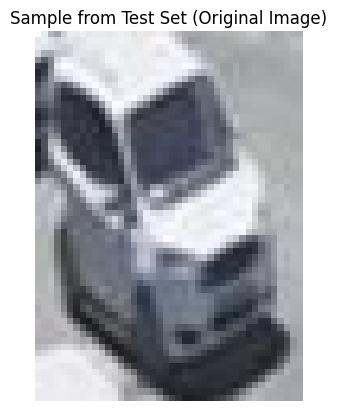

Model Prediction: car
Real Label:       car
------------------------------


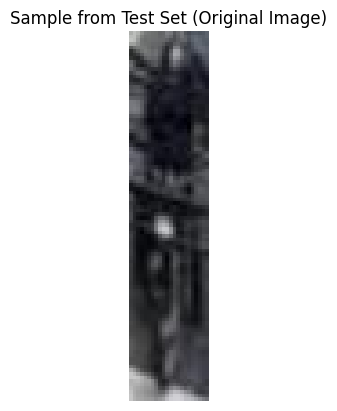

Model Prediction: pedestrian
Real Label:       pedestrian
------------------------------


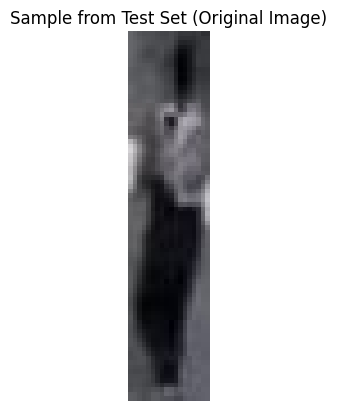

Model Prediction: car
Real Label:       pedestrian
------------------------------


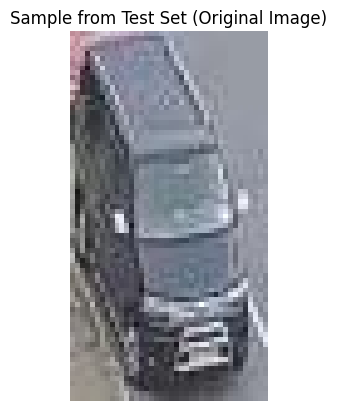

Model Prediction: car
Real Label:       car
------------------------------


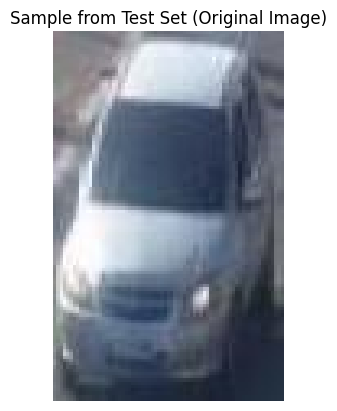

Model Prediction: car
Real Label:       car
------------------------------


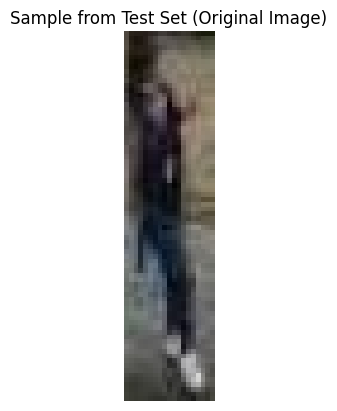

Model Prediction: pedestrian
Real Label:       pedestrian
------------------------------


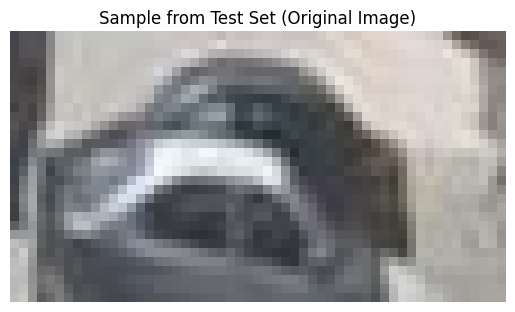

Model Prediction: car
Real Label:       car
------------------------------


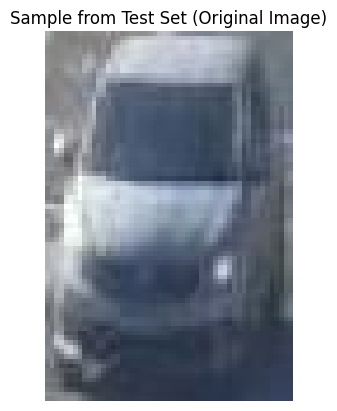

Model Prediction: car
Real Label:       car
------------------------------


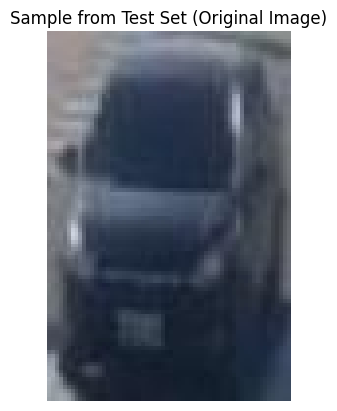

Model Prediction: car
Real Label:       car
------------------------------


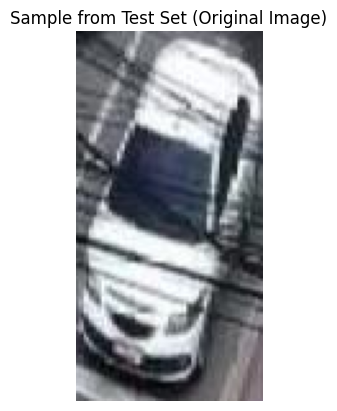

Model Prediction: car
Real Label:       car
------------------------------


In [117]:
import matplotlib.pyplot as plt
import random

# Get a few samples from the test dataset
num_samples_to_show = 40
random_indices = random.sample(range(len(test_only_filtered_dataset)), min(num_samples_to_show, len(test_only_filtered_dataset)))

model.eval()
with torch.no_grad():
    for i in random_indices:
        img_path, lbl_path = test_only_filtered_dataset.samples[i] # Get the original image path
        img_tensor, true_label_idx = test_only_filtered_dataset[i] # Get the transformed tensor and label index

        # Load the original image for display
        original_img = Image.open(img_path).convert("RGB")

        # Display the image
        plt.imshow(original_img)
        plt.axis('off')
        plt.title(f"Sample from Test Set (Original Image)")
        plt.show()

        # Prepare the image tensor for the model
        img_tensor = img_tensor.unsqueeze(0).to(device) # Add batch dimension and move to device

        # Get the model's prediction
        output = model(img_tensor)
        pred_label_idx = output.argmax(dim=1).item()

        # Get the class names
        true_label_name = CLASS_NAMES_LIST[true_label_idx]
        pred_label_name = CLASS_NAMES_LIST[pred_label_idx]

        print(f"Model Prediction: {pred_label_name}")
        print(f"Real Label:       {true_label_name}")
        print("-" * 30)
